## Questões

Utilize o dataset MNIST.

Realize a classificação utilizando o kNN, Decision Tree, Random Forest, Naive Bayes Gaussiano, MLP e SVM. Calcule métricas adequadas para o problema e justifique suas escolhas.

Utilize o K-means. Realize experimentos com 10 clusters.

Realize diferentes experimentos (o uso de técnicas de otimização de hiperparametros é opcional). Altere:
k do kNN
número de florestas no Random Forest
‘critério’ do Decision Tree
quantidade de neurônios no MLP para uma e duas camadas ocultas.
kernel, C, degree,  do SVM (observe que são diferentes hiperparametros para cada kernel)

Utilize o t-SNE para redução de dimensionalidade.

Realize a normalização e padronização dos dados, utilize o melhor classificador.

Discuta os resultados.


## Importação dos dados

In [2]:
import numpy as np
import seaborn as sb
import keras
import pandas as pd
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [3]:
(X_train,y_train), ( X_test, y_test) = keras.datasets.mnist.load_data()


In [4]:
X_train = np.reshape(X_train, (60000,784))
X_test = np.reshape(X_test, (10000,784))

## Normalizando e padronizando os dados

In [5]:
transformer = Normalizer().fit(X_train)
X_train = transformer.transform(X_train)
transformer = Normalizer().fit(X_test)
X_test = transformer.transform(X_test)

In [8]:
transformer = StandardScaler().fit(X_train)
X_train = transformer.transform(X_train)
transformer = StandardScaler().fit(X_test)
X_test = transformer.transform(X_test)

## Treinando modelo

### Classificação por K-Vizinhos 

In [12]:
modelo = KNeighborsClassifier().fit(X_train, y_train) 
knn_predict = modelo.predict(X_test)

In [13]:
print('Precisão')
print(accuracy_score(y_test, knn_predict))
print('Resumo')
print(classification_report(y_test, knn_predict))

Precisão
0.9415
Resumo
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       980
           1       0.96      0.99      0.98      1135
           2       0.95      0.93      0.94      1032
           3       0.92      0.95      0.94      1010
           4       0.96      0.93      0.95       982
           5       0.94      0.91      0.92       892
           6       0.95      0.97      0.96       958
           7       0.92      0.94      0.93      1028
           8       0.95      0.89      0.92       974
           9       0.92      0.91      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



### Classificação por arvore de decisão

In [12]:
modelo= DecisionTreeClassifier().fit(X_train, y_train)
decision_tree_predict = modelo.predict(X_test)

In [14]:
print('Precisão')
print(accuracy_score(y_test,decision_tree_predict))
print('Resumo')
print(classification_report(y_test,decision_tree_predict))

Precisão
0.8786
Resumo
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       980
           1       0.96      0.96      0.96      1135
           2       0.86      0.85      0.85      1032
           3       0.83      0.85      0.84      1010
           4       0.88      0.89      0.88       982
           5       0.83      0.84      0.84       892
           6       0.89      0.88      0.89       958
           7       0.92      0.90      0.91      1028
           8       0.82      0.81      0.81       974
           9       0.86      0.86      0.86      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



### Classificação por floresta aleatória

In [7]:
modelo = RandomForestClassifier().fit(X_train, y_train)
random_forest_predict = modelo.predict(X_test)

In [8]:
print('Precisão')
print(accuracy_score(y_test, random_forest_predict))
print('Resumo')
print(classification_report(y_test, random_forest_predict))

Precisão
0.9698
Resumo
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.98      0.97       982
           5       0.98      0.96      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.95      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



### Classificação SVC

In [131]:
modelo = SVC().fit(X_train, y_train)
svc_predict = modelo.predict(X_test)
print('Precisão')
print(accuracy_score(y_test, svc_predict))

Precisão
0.9811


### Classificação Naive Bayes Gaussian

In [34]:
modelo = GaussianNB().fit(X_train, y_train)
nbg_predict = modelo.predict(X_test)
print('Precisão')
print(accuracy_score(y_test, nbg_predict))

Precisão
0.5558


### MLP

In [14]:
modelo = MLPClassifier().fit(X_train, y_train)
y_predict = modelo.predict(X_test)
print('Precisão')
print(accuracy_score(y_test, y_predict))

Precisão
0.9769


## TSNE

In [126]:
modelo = TSNE(n_components=2, random_state=0)
X_train_tsne = modelo.fit_transform(X_train[1:1000,:])

In [127]:
df = {}
df['x'] = X_train_tsne[:, 0]
df['y'] = X_train_tsne[:,1]
df['target'] =  y_train[1:1000]
df = pd.DataFrame(df)

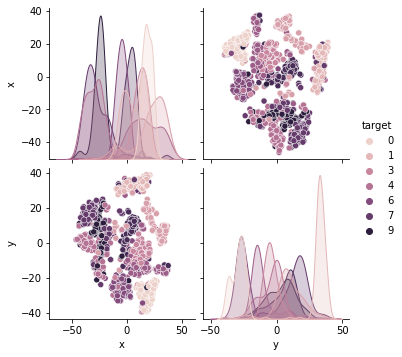

In [129]:
sb.pairplot(df, hue ='target')

## Melhorando classificadores

### KNN Melhorado

In [30]:
for i in range(1,10,2):
    modelo = KNeighborsClassifier(n_neighbors=i).fit(X_train, y_train)
    print(f'Acurácia com {i} vizinhos igual a: {accuracy_score(y_test, modelo.predict(X_test))}')

Acurácia com 1 vizinhos igual a: 0.9723
Acurácia com 3 vizinhos igual a: 0.9733
Acurácia com 5 vizinhos igual a: 0.973
Acurácia com 7 vizinhos igual a: 0.9727
Acurácia com 9 vizinhos igual a: 0.9717


### Random Search melhorado

In [31]:
for i in range(25,176,25):
    modelo = RandomForestClassifier(max_depth=i).fit(X_train, y_train)
    print(f'Acurácia com {i} de profundidade máxima igual a: {accuracy_score(y_test, modelo.predict(X_test))}')


Acurácia com 25 vizinhos igual a: 0.968
Acurácia com 50 vizinhos igual a: 0.9678
Acurácia com 75 vizinhos igual a: 0.9682
Acurácia com 100 vizinhos igual a: 0.9682
Acurácia com 125 vizinhos igual a: 0.9669
Acurácia com 150 vizinhos igual a: 0.9681
Acurácia com 175 vizinhos igual a: 0.9691


### Random search Decision tree 

In [32]:
modelo = DecisionTreeClassifier()
params = {'splitter':['best', 'random'], 'criterion':['gini','entropy']}
clf = RandomizedSearchCV(modelo, params, n_iter=3)
clf.fit(X_train,y_train)
y_predict = clf.predict(X_test)
print('Precisão')
print(accuracy_score(y_test, y_predict))

Precisão
0.8828


### MLP Melhorado

In [8]:
params = {'hidden_layer_sizes': [(50,50),(100,),(75,25), (100, 100)], 'max_iter':[500,700], 'solver':['lbfgs', 'sgd','adam']}
clf = RandomizedSearchCV(MLPClassifier(), params, n_iter=3)
clf.fit(X_train,y_train)
y_predict = clf.predict(X_test)
print('Precisão')
print(accuracy_score(y_test, y_predict))

/home/geovanebarros/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/geovanebarros/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/geovanebarros/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/geovanebarros/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
params = {'kernel': ['linear','poly', 'rbf', 'sigmoid'], 'gamma':['scale', 'auto'], 'degree':[3,5,7]}
clf = RandomizedSearchCV(MLPClassifier(), params, n_iter=3)
clf.fit(X_train,y_train)
y_predict = clf.predict(X_test)
print('Precisão')
print(accuracy_score(y_test, y_predict))